# Simple Classifiers and preprocessing of the data

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np


SEED = 42

## Importing of the data and spliting

next, we will import the dataset:

In [2]:
CSV_PATH = '../data/chartex_final.csv'

df = pd.read_csv(CSV_PATH)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3932 entries, 0 to 3931
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_name         3932 non-null   object 
 1   track_pop          3932 non-null   int64  
 2   artist             3932 non-null   object 
 3   artist_pop         3932 non-null   int64  
 4   album              3932 non-null   object 
 5   danceability       3932 non-null   float64
 6   energy             3932 non-null   float64
 7   key                3932 non-null   float64
 8   loudness           3932 non-null   float64
 9   mode               3932 non-null   float64
 10  speechiness        3932 non-null   float64
 11  acousticness       3932 non-null   float64
 12  instrumentalness   3932 non-null   float64
 13  liveness           3932 non-null   float64
 14  valence            3932 non-null   float64
 15  tempo              3932 non-null   float64
 16  id                 3932 

Let's fill all missing data with the expectation:

In [3]:
df = df.drop(['track_name', 'artist', 'album', 'id', 'song_name', 'artist_name'], axis = 1, errors = 'ignore')
means = df.mean()
df.fillna(value=means, inplace=True)

next, we will split the target feature (number_of_videos) from the rest of the features and split to train and test sets. In addition, we will replace number_of_videos with a new binary feature that indicate if a track is popular on tiktok according to number_of_videos and threshold of our choice and it will be out target feature for **classification**:

In [4]:
from sklearn.model_selection import train_test_split

df = df.drop(['artist_pop', 'track_pop', 'number_of_videos_last_14days', 'total_likes_count', 'key'], axis = 1, errors = 'ignore')
columns = df.columns

X, y = df.drop(['number_of_videos'], axis=1, errors = 'ignore').values,  df['number_of_videos'].values

Let's look at the distribution of the target feature and also its mean and few quantiles:

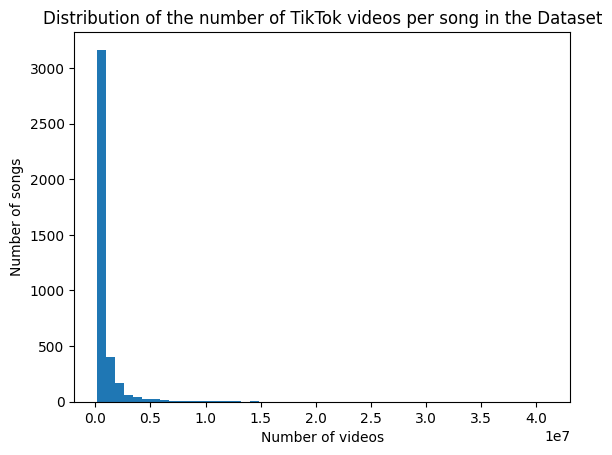

In [5]:
import matplotlib.pyplot as plt

plt.hist(y, bins=50)
plt.title("Distribution of the number of TikTok videos per song in the Dataset")
plt.xlabel("Number of videos")
plt.ylabel("Number of songs")
plt.show()

In [6]:
p = [0.3,0.4,0.5,0.6,0.7]
q = np.quantile(y, p)

print(f'Mean of target feature: {np.mean(y)} .')

for prob, quant in zip(p,q):
    print(f'The quantile of {prob} is {quant} .')

y_min = np.min(y)
y_max = np.max(y)

print(f'The max value is {y_max} and the min value is {y_min} .')
print(f'The range of the target feature is {y_max - y_min} .')

Mean of target feature: 794857.4763479145 .
The quantile of 0.3 is 230794.4 .
The quantile of 0.4 is 277940.0 .
The quantile of 0.5 is 345250.0 .
The quantile of 0.6 is 443660.0 .
The quantile of 0.7 is 607300.0 .
The max value is 41049300 and the min value is 147400 .
The range of the target feature is 40901900 .


We can notice that the mean of y is higher than the quantile of 0.7 (which is make sense considering the distribution of the target, as we can see in the plot above). We wish to have as balanced as possible data and therefore the mean is not the right threshold. On the other hand, the median is very low value considering the min and max of the target (it is very close to the min and very far from the max). Therefore, we will choose 500,000 as the threshold (still balanced).

In [7]:
y = (y > 5e5).astype('int32')

To conclude, for now, the features we will work on are:

In [8]:
print(f'Target: number_of_videos')
i = 0
for column in columns:
    if not column == 'number_of_videos':
        print(f'#{i} : {column}')
        i+=1

Target: number_of_videos
#0 : danceability
#1 : energy
#2 : loudness
#3 : mode
#4 : speechiness
#5 : acousticness
#6 : instrumentalness
#7 : liveness
#8 : valence
#9 : tempo
#10 : duration_ms
#11 : time_signature
#12 : chroma_stft
#13 : rmse
#14 : spec_cent
#15 : spec_bw
#16 : rolloff
#17 : zcr
#18 : mfcc


And now we will split the data between training and test sets:

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = SEED, test_size=0.25)

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Let's investigate a bit the train and test sets:

In [11]:
print("Train:")
print("#samples in train:", y_train.shape[0])
print("#popular samples in train:", y_train.sum().item()/y_train.shape[0])

print("\nTest:")
print("#samples in test:", y_test.shape[0])
print("#popular samples in test:", y_test.sum().item()/y_test.shape[0])

Train:
#samples in train: 2949
#popular samples in train: 0.35232282129535436

Test:
#samples in test: 983
#popular samples in test: 0.38351983723296035


## Simple classifiers:

In [12]:
from sklearn.model_selection import cross_validate
import torch

def print_accuracy(model, X_train, X_test, y_train, y_test):
    y_pred = model.predict(X_train)
    train_acc = (y_train == y_pred).mean()
    print("train accuracy =",train_acc)

    y_pred = model.predict(X_test)
    test_acc = (y_test == y_pred).mean()
    print("test accuracy =",test_acc)
    return train_acc,test_acc

def print_accuracy_prob(model, X_train, X_test, y_train, y_test):
    y_pred = model(X_train)
    train_acc = (torch.argmax(y_pred,dim=1) == y_train).type(torch.float32).mean().item()
    print("train accuracy =",train_acc)

    y_pred = model(X_test)
    test_acc = (torch.argmax(y_pred,dim=1) == y_test).type(torch.float32).mean().item()
    print("test accuracy =",test_acc)
    return train_acc,test_acc

splitted_data = (X_train, X_test, y_train, y_test)

In [13]:
clf_results = {'name': [], 'train_acc': [], 'test_acc': []}

### KNN

Now we are ready to train the models.

We will start with KNN:

In [14]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=8)

knn_model.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=8)

In [15]:
train_acc, test_acc = print_accuracy(knn_model, *splitted_data)
clf_results['name'].append('KNN with K=8')
clf_results['train_acc'].append(train_acc)
clf_results['test_acc'].append(test_acc)

train accuracy = 0.6914208206171584
test accuracy = 0.595116988809766


### SVM with RBF kernel:

We will try to train SVM with RBF kernel:

In [17]:
from sklearn.svm import SVC

svm_model = SVC(gamma='auto')
svm_model.fit(X_train,y_train)

SVC(gamma='auto')

In [18]:
train_acc, test_acc = print_accuracy(svm_model, *splitted_data)
clf_results['name'].append('SVM with RBF without CV')
clf_results['train_acc'].append(train_acc)
clf_results['test_acc'].append(test_acc)

train accuracy = 0.6476771787046457
test accuracy = 0.6164801627670397


In [19]:
gammas = [0.01, 0.1, 1, 10, 100]
reg_terms = [0.01, 0.1, 1, 10, 100]
accuracy_per_value = []

for reg in reg_terms:
    for gamma in gammas:
        svm_model = SVC(C=reg, gamma=gamma)
        cv_result = cross_validate(svm_model, X_train, y_train, cv=3, scoring= ('accuracy'))
        accuracy_per_value.append(cv_result['test_score'].mean())

optim_idx = np.argmax(accuracy_per_value)
svm_model = SVC(C=reg_terms[optim_idx//len(gammas)], gamma=gammas[optim_idx%len(gammas)])
svm_model.fit(X_train, y_train)

SVC(C=0.01, gamma=0.01)

In [20]:
train_acc, test_acc = print_accuracy(svm_model, *splitted_data)
clf_results['name'].append('SVM with RBF with CV')
clf_results['train_acc'].append(train_acc)
clf_results['test_acc'].append(test_acc)

train accuracy = 0.6476771787046457
test accuracy = 0.6164801627670397


### Decision Trees:

Let's put regularization by forcing all leaves in the tree to have at least 10 samples from the training set:

In [21]:
from sklearn import tree

tree_model = tree.DecisionTreeClassifier(criterion = 'entropy', min_samples_split = 10)

tree_model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', min_samples_split=10)

In [22]:
train_acc, test_acc = print_accuracy(tree_model, *splitted_data)
clf_results['name'].append('Decision Tree without CV')
clf_results['train_acc'].append(train_acc)
clf_results['test_acc'].append(test_acc)

train accuracy = 0.9321804001356392
test accuracy = 0.5178026449643948


Has we can see from the result, the model suffers from overfitting. So, let's do cross validation on min_samples_split:

In [23]:
from sklearn import tree

list_of_mins = [10,50,100,300,500,1000]
accuracy_per_value = []

for min_leaf in list_of_mins:
    tree_model = tree.DecisionTreeClassifier(criterion = 'entropy', min_samples_split = min_leaf)
    cv_result = cross_validate(tree_model, X_train, y_train, cv=3, scoring= ('accuracy'))
    accuracy_per_value.append(cv_result['test_score'].mean())

optim_min = list_of_mins[np.argmax(accuracy_per_value)]
tree_model = tree.DecisionTreeClassifier(criterion = 'entropy', min_samples_split = optim_min)
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', min_samples_split=500)

And then, the accuracies of the model with the optimal min_samples_split is:

In [24]:
train_acc, test_acc = print_accuracy(tree_model, *splitted_data)
clf_results['name'].append('Decision Tree with CV')
clf_results['train_acc'].append(train_acc)
clf_results['test_acc'].append(test_acc)

train accuracy = 0.671414038657172
test accuracy = 0.6012207527975585


Still not a good result. We need to remember that we are still working on the row data and didn't do any feature mapping

### AdaBoost classifier:

Let's play with AdaBoost a bit:

In [25]:
from sklearn.ensemble import AdaBoostClassifier

#the base model is stump - decision tree with maximal depth of 1.
adaboost_model = AdaBoostClassifier(n_estimators=50, learning_rate=20)
adaboost_model.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=20)

In [26]:
train_acc, test_acc = print_accuracy(adaboost_model, *splitted_data)
clf_results['name'].append('Adaboost without CV')
clf_results['train_acc'].append(train_acc)
clf_results['test_acc'].append(test_acc)

train accuracy = 0.6490335707019329
test accuracy = 0.6174974567650051


Let's see if Cross validation can help it:

In [27]:
estimators = [10, 25, 50]
lr = [0.01, 0.1, 1]
accuracy_per_value = []

for n_estimator in estimators:
    for rate in lr:
        adaboost_model = AdaBoostClassifier(n_estimators=n_estimator, learning_rate= rate)
        cv_result = cross_validate(adaboost_model, X_train, y_train, cv=3, scoring= ('accuracy'))
        accuracy_per_value.append(cv_result['test_score'].mean())

optim_idx = np.argmax(accuracy_per_value)
adaboost_model = AdaBoostClassifier(n_estimators= estimators[optim_idx//len(lr)], learning_rate= lr[optim_idx%len(lr)])
adaboost_model.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=0.01, n_estimators=10)

In [28]:
train_acc, test_acc = print_accuracy(adaboost_model, *splitted_data)
clf_results['name'].append('Adaboost with CV')
clf_results['train_acc'].append(train_acc)
clf_results['test_acc'].append(test_acc)

train accuracy = 0.6476771787046457
test accuracy = 0.6164801627670397


### MLP model:

Let's check how many features we have:

In [14]:
input_dim = X_train.shape[1]
output_dim = 2
train_samples = X_train.shape[0]

print("input dim:", input_dim)
print("number of train samples:", train_samples)
print("number of test samples:", X_test.shape[0])

input dim: 19
number of train samples: 2949
number of test samples: 983


In [15]:
import torch
import torch.nn as nn
from src.RNN_utils.dataset import SimpleDS

torch.manual_seed(SEED)

X_train = torch.tensor(X_train, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.long)

X_test = torch.tensor(X_test, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.long)

splitted_data_torch = (X_train, X_test, y_train, y_test)

#### Overfitting on small subset test:

We will start by checking if it is possible to overfit the MLP on small subset of the training set: (in order to see if the implementation of trainer and dataIterator module are good):

In [24]:
train_ds = SimpleDS(X_train[:50], y_train[:50])

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=False)

In [28]:
overfit_model = nn.Sequential(
    nn.BatchNorm1d(input_dim),
    nn.Linear(input_dim, 16),
    nn.LeakyReLU(),
    nn.Linear(16, output_dim),
    nn.Softmax(dim=1)
)

print(overfit_model)

Sequential(
  (0): BatchNorm1d(19, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Linear(in_features=19, out_features=16, bias=True)
  (2): LeakyReLU(negative_slope=0.01)
  (3): Linear(in_features=16, out_features=2, bias=True)
  (4): Softmax(dim=1)
)


In [29]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(overfit_model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=100,gamma=1)

In [30]:
from src.RNN_utils.trainer import trainer

overfit_trainer = trainer(overfit_model, loss_fn, optimizer,scheduler)

loss_list, accuracy_list = overfit_trainer.train(train_dl, 100, False)

100%|██████████| 100/100 [00:00<00:00, 588.43it/s]

Epoch #99: Loss - 0.3341589868068695, Accuracy - 0.98


Success! Now we can move on to a real training.

#### Simple MLP:

In [17]:
train_ds = SimpleDS(X_train, y_train)
test_ds = SimpleDS(X_test, y_test)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=32, shuffle=False)

In [21]:
mlp_model = nn.Sequential(
    nn.BatchNorm1d(input_dim),
    nn.Linear(input_dim, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 2),
    nn.Softmax(dim=1)
)

print(mlp_model)

Sequential(
  (0): BatchNorm1d(19, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Linear(in_features=19, out_features=64, bias=True)
  (2): ReLU()
  (3): Linear(in_features=64, out_features=64, bias=True)
  (4): ReLU()
  (5): Linear(in_features=64, out_features=2, bias=True)
  (6): Softmax(dim=1)
)


In [22]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.2)

num_epochs = 100

In [23]:
from src.RNN_utils.trainer import trainer

mlp_trainer = trainer(mlp_model, loss_fn, optimizer, scheduler)

resutls = mlp_trainer.train(train_dl, num_epochs, False)

100%|██████████| 100/100 [00:13<00:00,  7.19it/s]

Epoch #99: Loss - 55.28169947862625, Accuracy - 0.7070193285859614


Text(0, 0.5, 'accuracy')

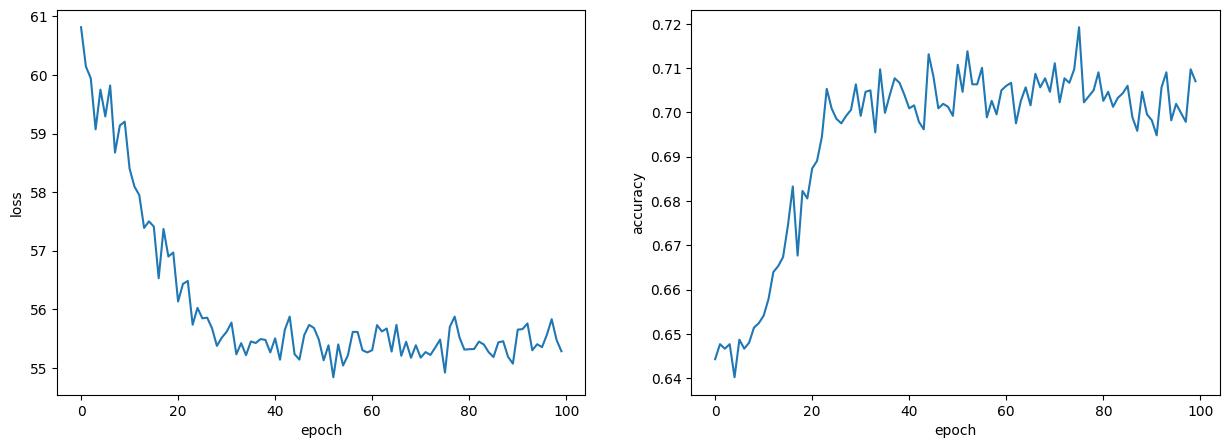

In [24]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2, figsize=(15,5))

axs[0].plot(range(num_epochs), resutls['loss'])
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')

axs[1].plot(range(num_epochs), resutls['accuracy'])
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('accuracy')


In [25]:
train_acc, test_acc = print_accuracy_prob(mlp_model, *splitted_data_torch)
clf_results['name'].append('MLP without CV')
clf_results['train_acc'].append(train_acc)
clf_results['test_acc'].append(test_acc)

train accuracy = 0.7307561635971069
test accuracy = 0.5920650959014893


It seems that the learning rate is not correct because the loss graph is fluctuating.

We will next do cross validation on few hyperparameters in order to get the better model.

#### Cross validation for MLP:

In [16]:
import torch
import torch.nn as nn
from src.cross_val import setConfigure
from src.RNN_utils.cross_val import crossValidate
from sklearn.model_selection import KFold
from src.RNN_utils.trainer import trainer

In [18]:
CV_obj = crossValidate(train_ds,5,64)

In [19]:
CV_obj = crossValidate(train_ds,5,64)

def crossValidationForHP(configures, num_epochs = 100):
    results = []
    configs = []

    for config in configures:
        mlp_model = nn.Sequential(
            nn.BatchNorm1d(input_dim),
            nn.Linear(input_dim, 32),
            nn.LeakyReLU(),
            nn.Dropout1d(p=0.2),
            nn.Linear(32, 32),
            nn.LeakyReLU(),
            nn.Dropout1d(p=0.2),
            nn.Linear(32, output_dim),
            nn.Softmax(dim=1)
        )
        print(f'The configuration is {config}:')
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(mlp_model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=config['step_size'],gamma=config['gamma'])

        trainer_obj = trainer(mlp_model,loss_fn,optimizer,scheduler)

        results.append(CV_obj.runCV(trainer_obj,num_epochs,verbose=False))
        configs.append(f"lr: {config['lr']}")
    return (results, configs)

In [20]:
configures = setConfigure({'lr': [1e-3,5e-4,1e-4,5e-5], 'weight_decay': [3e-4], 'step_size': [15], 'gamma': [0.5]})
results, configs = crossValidationForHP(configures)

The configuration is {'lr': 0.001, 'weight_decay': 0.0003, 'step_size': 15, 'gamma': 0.5}:
Fold #0:
Result:  {'loss_train': 22.208392679691315, 'accuracy_train': 0.7045358202628232, 'loss_test': 6.713170826435089, 'accuracy_test': 0.6}
Fold #1:
Result:  {'loss_train': 22.370300114154816, 'accuracy_train': 0.7002967359050445, 'loss_test': 6.719740211963654, 'accuracy_test': 0.6067796610169491}
Fold #2:
Result:  {'loss_train': 22.293931901454926, 'accuracy_train': 0.7075031793132683, 'loss_test': 6.469731867313385, 'accuracy_test': 0.6152542372881356}
Fold #3:
Result:  {'loss_train': 22.01021134853363, 'accuracy_train': 0.7138618058499364, 'loss_test': 6.622070491313934, 'accuracy_test': 0.635593220338983}
Fold #4:
Result:  {'loss_train': 22.070614457130432, 'accuracy_train': 0.7084745762711865, 'loss_test': 6.435924589633942, 'accuracy_test': 0.6095076400679117}
The configuration is {'lr': 0.0005, 'weight_decay': 0.0003, 'step_size': 15, 'gamma': 0.5}:
Fold #0:
Result:  {'loss_train': 2

In [34]:
mlp_model = nn.Sequential(
    nn.BatchNorm1d(input_dim),
    nn.Linear(input_dim, 32),
    nn.LeakyReLU(),
    nn.Dropout1d(p=0.2),
    nn.Linear(32, 32),
    nn.LeakyReLU(),
    nn.Dropout1d(p=0.2),
    nn.Linear(32, output_dim),
    nn.Softmax(dim=1)
)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=1e-3, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=15,gamma=0.5)
mlp_model.train()
trainer_obj = trainer(mlp_model,loss_fn,optimizer,scheduler)
trainer_obj.train(train_dl,100,False)

100%|██████████| 100/100 [00:14<00:00,  6.70it/s]

Epoch #99: Loss - 58.685943961143494, Accuracy - 0.6632756866734486


{'loss': [62.70243489742279,
  61.30522561073303,
  60.76610493659973,
  60.78635734319687,
  61.03262734413147,
  60.28498673439026,
  60.479110926389694,
  60.186719834804535,
  59.89131426811218,
  59.88343584537506,
  60.10877615213394,
  59.63700348138809,
  59.992451906204224,
  59.739504754543304,
  59.493323802948,
  59.58256220817566,
  59.51571887731552,
  59.628650188446045,
  59.276296466588974,
  59.70202088356018,
  59.500744581222534,
  59.77033466100693,
  59.449811398983,
  59.52633845806122,
  59.27167734503746,
  59.328764259815216,
  59.32843792438507,
  59.25970035791397,
  59.365283608436584,
  59.27231466770172,
  59.22214329242706,
  59.2517774105072,
  59.01506066322327,
  59.076665222644806,
  59.05624681711197,
  59.02133256196976,
  59.19358742237091,
  59.27227544784546,
  59.03998923301697,
  59.30749213695526,
  58.892838418483734,
  58.962281316518784,
  59.106128096580505,
  59.174418807029724,
  58.87520271539688,
  58.962423890829086,
  59.13947248458

In [41]:
trainer_obj.model.eval()
trainer_obj.evaluate(train_dl)

(57.943509101867676, 0.6585283146829434)

In [37]:
y_train.sum()

tensor(1039)

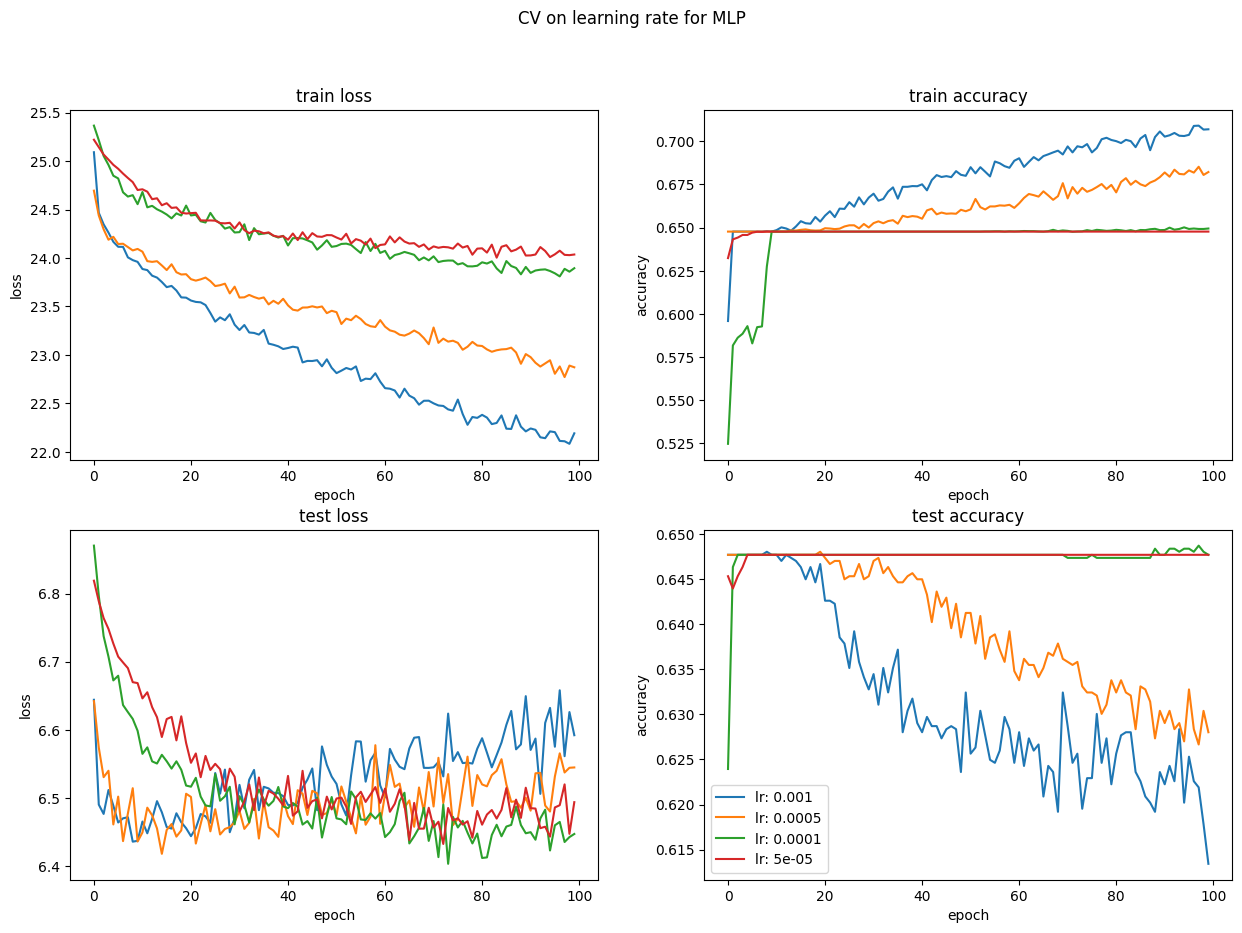

In [21]:
from src.RNN_utils.cross_val import plotCV

plotCV(results, configs,title='CV on learning rate for MLP')

In [ ]:
configures = [{'lr': 1e-4, 'weight_decay': 7e-4, 'step_size': 5, 'gamma': 0.5},\
                {'lr': 1e-4, 'weight_decay': 7e-4, 'step_size': 10, 'gamma': 0.5},\
                {'lr': 1e-4, 'weight_decay': 7e-4, 'step_size': 15, 'gamma': 0.5},\
                {'lr': 1e-4, 'weight_decay': 7e-4, 'step_size': 20, 'gamma': 0.1}]

In [ ]:
from src.RNN_utils.cross_val import plotCV

plotCV(results, configs,title='CV on weight decay for MLP')

The curves on the training set behaves as expected, the loss decreases and the accuracy increased. However, on the validation graphs, its seems there is an overfitting but its started on the first epoch. We suspect the reason for that is that we are missing and essential feature, which prevents us from generalize the learning and thus getting overfitted to the training set.

We will still choose a configuration and see the results on the test set. The red curve did the best in both training and validation and thus we will choose the following configuration:

In [26]:
config = {'lr': 1e-3, 'weight_decay': 5e-4}

mlp_model = nn.Sequential(
        nn.BatchNorm1d(input_dim),
        nn.Linear(input_dim, 32),
        nn.LeakyReLU(),
        nn.Linear(32, 64),
        nn.LeakyReLU(),
        nn.Linear(64, output_dim),
        nn.Softmax(dim=1)
)


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=20,gamma=0.1)

mlp_trainer = trainer(mlp_model,loss_fn, optimizer, scheduler)

In [27]:
train_res = mlp_trainer.train(train_dl=train_dl, epochs=100, verbose=False)

100%|██████████| 100/100 [00:13<00:00,  7.25it/s]

Epoch #99: Loss - 57.72852212190628, Accuracy - 0.6741268226517464


Text(0, 0.5, 'accuracy')

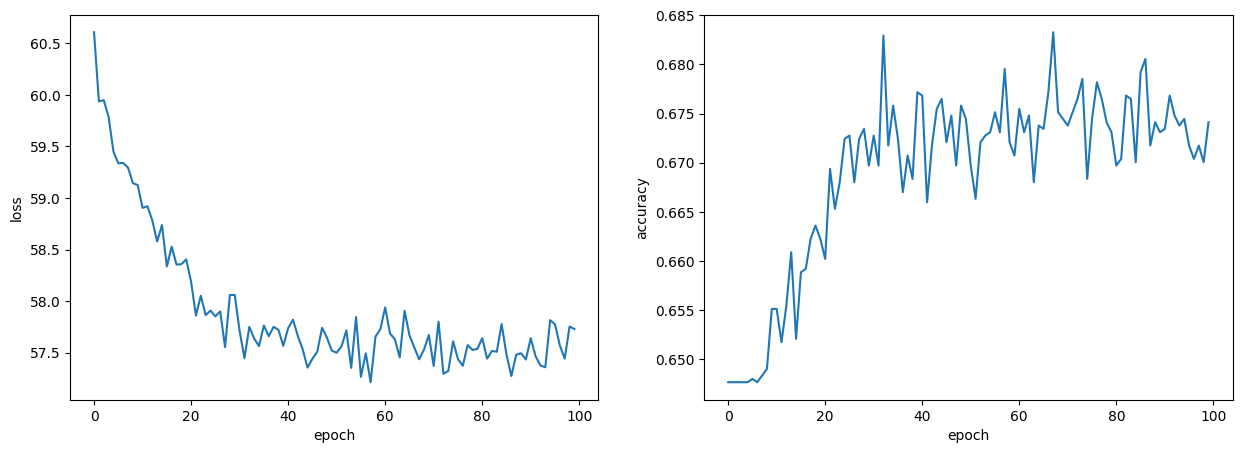

In [28]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2, figsize=(15,5))

axs[0].plot(range(100), train_res['loss'])
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')

axs[1].plot(range(100), train_res['accuracy'])
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('accuracy')

In [29]:
train_acc, test_acc = print_accuracy_prob(mlp_model, *splitted_data_torch)
clf_results['name'].append('MLP with CV')
clf_results['train_acc'].append(train_acc)
clf_results['test_acc'].append(test_acc)

train accuracy = 0.6802305579185486
test accuracy = 0.6042726635932922


Worse than without cross validation. We have a problem here.

### Conclusions:

Let's summarize the output:

In [63]:
clf_dataframe = pd.DataFrame.from_dict(clf_results)
clf_dataframe

,name,train_acc,test_acc
0,KNN,0.691421,0.595117
1,SVM with RBF without CV,0.647677,0.616480
2,SVM with RBF with CV,0.647677,0.616480
3,Decision Tree without CV,0.930485,0.528993
4,Decision Tree with CV,0.669719,0.605290
5,Adaboost without CV,0.649034,0.617497
6,Adaboost with CV,0.647677,0.616480
7,MLP without CV,0.691082,0.607325
8,MLP with CV,0.756189,0.580875


From the above table, adaBoost without CV got the best results on the training set. However, even the best is not good. As explained before, we think the reason for that is a missing for important feature that determine the popularity of songs. In other words, both spotify features and the self-extracted features we made are not enough to classify the popularity of songs. We hope that by working with the real audio, we will be able to extract this essential feature (or features) and will be able to do better than the results in this notebook.

### Others:

In [64]:
#Save the entire model:
#torch.save(model, "my_model.pickle")
#model = torch.load("my_model.pickle")

#Save only the weights: (recommended)
#torch.save(model.state_dict(), "my_model.pickle")
#model = nn.Sequential(...)
#model.load_state_dict(torch.load("my_model.pickle"))